## Contents
1. Setup

## 1. Setup

In [3]:
%run "./3. Estimator pipelines"

The below code is used to create a function which easily displays Pandas DataFrames and shows their information as clearly as possible

In [5]:
def display_pdf(a_pdf):
  display(spark.createDataFrame(a_pdf,verifySchema=False))

Below, the code functions as a sort of wrapper class to be applied to grid search objects in order to make their output easily readable and removes certain unnecessary columns from the output such as any column beginning with split.  It returns the grid search results sorted from best to worst performing.

In [7]:
def est_grid_results_pdf(my_est_grid_obj,est_tag=None,fea_tag=None): 
  import pandas as pd
  import numpy  as np
  res_pdf = pd.DataFrame(data=my_est_grid_obj.cv_results_) \
           .loc[:,lambda df: np.logical_or(df.columns.str.startswith('param_'),
                                           df.columns.str.endswith('test_score'))
               ] \
           .loc[:,lambda df: np.logical_not(df.columns.str.startswith('split'))
               ] \
   #        .drop(['rank_test_score', 'std_test_score'], axis=1)
  res_pdf.columns = [column.replace('param_','') for column in list(res_pdf.columns)]
  if est_tag is not None: res_pdf = res_pdf.assign(est_tag=est_tag)
  if fea_tag is not None: res_pdf = res_pdf.assign(fea_tag=fea_tag)
  return res_pdf.sort_values('mean_test_score', ascending = False)

##Grid Search to Find Best Model

In the next block of code we will work to determine the best model for each of our three regression methods.  Our exploration will include in this case finding optimal number of Principal Components, the optimal Alpha level, and if normalized or non-normalized data and scaled data is better at predicting.

### Model Ridge

From here we begin our process, using a simple grid search pipeline to determine how the model will look and get a general sense of what is going on

In [12]:
simple_gs_ridge = \
GridSearchCV(sc,
             estimator=PCA_Ridge_Pipeline,
             param_grid={'rdg__normalize'   :[True, False],
                         'rdg__alpha'       :[10.0**n for n in [-3,0,3]],
                         'rdg__solver'      :['saga'],
                         'pca__n_components':[10**n for n in [1, 2, 3]]
             },
  cv=TimeSeriesSplit(n_splits=5),
  scoring=make_scorer(r2_score),
  return_train_score=False,
  n_jobs=-1 
) 
simple_gs_ridge.fit(trn_fea_pdf_lag1, trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_ridge,est_tag='pca-rdg'))

mean_test_score,pca__n_components,rdg__alpha,rdg__normalize,rdg__solver,rank_test_score,std_test_score,est_tag
0.8560136223326306,100,0.001,true,saga,1,0.11659114030300174,pca-rdg
0.6263080488241506,10,0.001,true,saga,2,0.25535480285009876,pca-rdg
0.5934728616405281,100,1000.0,false,saga,3,0.30306264410462497,pca-rdg
0.5932434890935679,10,1000.0,false,saga,4,0.3031657299673669,pca-rdg
0.5929912428150443,1000,0.001,false,saga,5,0.30383694221280316,pca-rdg
0.5928233721156807,1000,1000.0,false,saga,6,0.30401043457386695,pca-rdg
0.5928229076482792,10,1.0,false,saga,7,0.304377894395776,pca-rdg
0.5927398910890659,1000,1.0,false,saga,8,0.30433120287385446,pca-rdg
0.5926387814252925,100,1.0,false,saga,9,0.3042567060724024,pca-rdg
0.5925284595010845,100,0.001,false,saga,10,0.3044141512981344,pca-rdg


From the above, we are able to make a couple of determinations.  Namely, the best performing models have a low ridge alpha, and a PCA somewhere around 100.  We also note that we want the ridge to be normalized from our observations.  Before adjusting the PCA and assigning a definite ridge alpha we will test what happens when applying a Scalar in the beginning of our pipeline

In [14]:
simple_gs_ridge_sca = \
GridSearchCV(sc,
             estimator=Sca_PCA_Ridge_Pipeline,
             param_grid={'rdg__normalize'   :[True, False],
                         'rdg__alpha'       :[10.0**n for n in [-3,0,3]],
                         'rdg__solver'      :['saga'],
                         'pca__n_components':[10**n for n in [1, 2, 3]]
             },
  cv=TimeSeriesSplit(n_splits=5),
  scoring=make_scorer(r2_score),
  return_train_score=False,
  n_jobs=-1 
) 
simple_gs_ridge_sca.fit(trn_fea_pdf_lag1, trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_ridge_sca,est_tag='pca-rdg'))

mean_test_score,pca__n_components,rdg__alpha,rdg__normalize,rdg__solver,rank_test_score,std_test_score,est_tag
0.3695212091917533,1000,0.001,false,saga,1,0.3832345436639787,pca-rdg
0.3678058762180972,1000,1.0,false,saga,2,0.3924604213936287,pca-rdg
0.2870866442141578,100,1.0,true,saga,3,0.20818136123022649,pca-rdg
0.21142607068136676,10,1.0,true,saga,4,0.24520160450944045,pca-rdg
-0.14035105241960388,100,0.001,true,saga,5,0.8434016296920213,pca-rdg
-0.1729474597047729,100,1.0,false,saga,6,0.94205329094194,pca-rdg
-0.1840188215192849,10,1.0,false,saga,7,0.6560438690058074,pca-rdg
-0.19623297011296692,100,0.001,false,saga,8,0.9268773181773211,pca-rdg
-0.19993362327107775,10,0.001,true,saga,9,0.6829392501335533,pca-rdg
-0.20347332872007204,10,0.001,false,saga,10,0.6853127114651734,pca-rdg


When compared to a non-scaled ridge regression, we note that the results are substantially worse - but what is more interesting is the difference in selection.  Here we have a higher PCA score, and normalization is set to false, most likely because we had pre-scaled the variables.  From here we will look to determine a more accurate score for PCA and ridge alpha.  Note that in order to achieve this we will need to change things slowly and precisely.

For the next GridSearch, we adjust the PCA components to range between 50 and 250, looking to identify a closer locus of points to focus on with the Ridge model.

In [17]:
simple_gs_ridge = \
GridSearchCV(sc,
             estimator=PCA_Ridge_Pipeline,
             param_grid={'rdg__normalize'   :[True, False],
                         'rdg__alpha'       :[10.0**n for n in [-3,0,3]],
                         'rdg__solver'      :['saga'],
                         'pca__n_components':[50,100,150,200,250]
             },
  cv=TimeSeriesSplit(n_splits=5),
  scoring=make_scorer(r2_score),
  return_train_score=False,
  n_jobs=-1 
) 
simple_gs_ridge.fit(trn_fea_pdf_lag1, trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_ridge,est_tag='pca-rdg'))

mean_test_score,pca__n_components,rdg__alpha,rdg__normalize,rdg__solver,rank_test_score,std_test_score,est_tag
0.8705724846568192,200,0.001,true,saga,1,0.1039167468277858,pca-rdg
0.8650008245727693,150,0.001,true,saga,2,0.10692584904519073,pca-rdg
0.854837481382233,100,0.001,true,saga,3,0.11821534100526793,pca-rdg
0.8042951815078746,50,0.001,true,saga,4,0.14777435897055358,pca-rdg
0.5935956371390044,100,1.0,false,saga,5,0.30288507822961763,pca-rdg
0.5935645936141596,150,0.001,false,saga,6,0.30308447226786217,pca-rdg
0.5935484175363226,250,1.0,false,saga,7,0.3029961124469695,pca-rdg
0.5934923154062973,50,1000.0,false,saga,8,0.3031867806228097,pca-rdg
0.5934725613186608,50,1.0,false,saga,9,0.3033279655069504,pca-rdg
0.5933754341379109,200,1.0,false,saga,10,0.30348096358908316,pca-rdg


We see improvement on the above by extending our range to include 200, 150, and such in the PCA analysis, but also note that the alpha is very small (.001) for all examples.  We will perform one more observation of PCA change, this time attempting to center in around 200 by considering a range between 175 and 225.

In [19]:
simple_gs_ridge = \
GridSearchCV(sc,
             estimator=PCA_Ridge_Pipeline,
             param_grid={'rdg__normalize'   :[True, False],
                         'rdg__alpha'       :[10.0**n for n in [-3,0,3]],
                         'rdg__solver'      :['saga'],
                         'pca__n_components':[175,190,200,215,225]
             },
  cv=TimeSeriesSplit(n_splits=5),
  scoring=make_scorer(r2_score),
  return_train_score=False,
  n_jobs=-1 
) 
simple_gs_ridge.fit(trn_fea_pdf_lag1, trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_ridge,est_tag='pca-rdg'))

mean_test_score,pca__n_components,rdg__alpha,rdg__normalize,rdg__solver,rank_test_score,std_test_score,est_tag
0.8724789643954419,200,0.001,true,saga,1,0.1026552522403339,pca-rdg
0.8716798004782808,190,0.001,true,saga,2,0.09702317148264478,pca-rdg
0.8706606596009699,175,0.001,true,saga,3,0.09979599722115161,pca-rdg
0.5933359250529153,225,1000.0,false,saga,4,0.3034585378344591,pca-rdg
0.5932389352420714,190,1000.0,false,saga,5,0.3036154478194395,pca-rdg
0.5932387513663794,200,1000.0,false,saga,6,0.30331332604797917,pca-rdg
0.5932183041655199,175,0.001,false,saga,7,0.3035705634059922,pca-rdg
0.5931314320427508,215,1.0,false,saga,8,0.30344576060467776,pca-rdg
0.5931298666331812,190,1.0,false,saga,9,0.30365360574659545,pca-rdg
0.5930282912006055,225,0.001,false,saga,10,0.30379332416139415,pca-rdg


We are unable to beat our previous score of 200, and with the narrow interval we were considering for the PCA analysis, we are satisfied with using 200 as the number of components for PCA analysis.  We will now look to test different values of alpha to see if this can be improved, as alpha currently sits at an edge.

In [21]:
simple_gs_ridge = \
GridSearchCV(sc,
             estimator=PCA_Ridge_Pipeline,
             param_grid={'rdg__normalize'   :[True],
                         'rdg__alpha'       :[.0001,.001, .01, .1],
                         'rdg__solver'      :['saga'],
                         'pca__n_components':[200]
             },
  cv=TimeSeriesSplit(n_splits=5),
  scoring=make_scorer(r2_score),
  return_train_score=False,
  n_jobs=-1 
) 
simple_gs_ridge.fit(trn_fea_pdf_lag1, trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_ridge,est_tag='pca-rdg'))

mean_test_score,pca__n_components,rdg__alpha,rdg__normalize,rdg__solver,rank_test_score,std_test_score,est_tag
0.8999409105084235,200,0.1,true,saga,1,0.04571908855130256,pca-rdg
0.8810598436972417,200,0.01,true,saga,2,0.08716243428581562,pca-rdg
0.8722833885067072,200,0.001,true,saga,3,0.10209036055534178,pca-rdg
0.8721647864168754,200,1.0E-4,true,saga,4,0.10280572375568424,pca-rdg


We find that the best score here again comes at a boundary, where alpha is .01.  We will need to test again a feasible range for alpha, and will do so by shifting the considerations.

In [23]:
simple_gs_ridge = \
GridSearchCV(sc,
             estimator=PCA_Ridge_Pipeline,
             param_grid={'rdg__normalize'   :[True],
                         'rdg__alpha'       :[.05,.1, .15, .2],
                         'rdg__solver'      :['saga'],
                         'pca__n_components':[200]
             },
  cv=TimeSeriesSplit(n_splits=5),
  scoring=make_scorer(r2_score),
  return_train_score=False,
  n_jobs=-1 
) 
simple_gs_ridge.fit(trn_fea_pdf_lag1, trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_ridge,est_tag='pca-rdg'))

mean_test_score,pca__n_components,rdg__alpha,rdg__normalize,rdg__solver,rank_test_score,std_test_score,est_tag
0.9043390776528374,200,0.15,true,saga,1,0.03150795789891425,pca-rdg
0.9030659219080619,200,0.1,true,saga,2,0.04299167026903124,pca-rdg
0.8941051454002834,200,0.2,true,saga,3,0.04381718338489716,pca-rdg
0.8932489280999699,200,0.05,true,saga,4,0.06800711676040967,pca-rdg


From this search, we determine the optimal alpha level is .15.  As this is no longer on a border and our range is relatively tight, we feel comfortable concluding that the optimal model for RIDGE is 200 PCA, .15 alpha, and normalized when the lag is 1. We will further explore how this model works when the lag is increased to 3 and will see what information is lost as a result, or if there is some sort of gain realized.

## Model Lasso

Rather than provide extensive comments for LASSO, we note that the modelling process will follow much the same goal as the RIDGE model above, we will start by observing what happens with scaled variables, and then attempt to home in on the best fit for alpha and pca components

In [27]:
simple_gs_lasso = \
GridSearchCV(sc,
             estimator=PCA_Lasso_Pipeline,
             param_grid={'pca__n_components': [10**n for n in [1,2,3]],
                         'lso__normalize'   :[True, False],
                         'lso__alpha'       : [10.0**n for n in [-3,0,3]],
                        },
             cv=TimeSeriesSplit(n_splits=5),
             scoring=make_scorer(r2_score),
             return_train_score=False,
             n_jobs=-1 
            ) 
simple_gs_lasso \
  .fit(trn_fea_pdf_lag1, 
       trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_lasso, est_tag='pca-lso'))

mean_test_score,lso__alpha,lso__normalize,pca__n_components,rank_test_score,std_test_score,est_tag
0.8534183592198212,1.0,false,1000,1,0.09281075731375286,pca-lso
0.8522153166602026,0.001,false,100,2,0.12583862207069724,pca-lso
0.8518954415682595,1.0,false,100,3,0.12088274149395285,pca-lso
0.8489059376041058,0.001,true,100,4,0.1299753997863471,pca-lso
0.8364092122796715,1.0,true,100,5,0.11629860620708891,pca-lso
0.6357943207257417,1.0,true,10,6,0.24604267048616849,pca-lso
0.6249740612736636,0.001,true,10,7,0.25598868807426783,pca-lso
0.624963393020049,1.0,false,10,8,0.25600646203705707,pca-lso
0.6249633576017621,0.001,false,10,9,0.2559982755869226,pca-lso
0.6205084976181986,1000.0,false,1000,10,0.2654786115688156,pca-lso


We note that here wee are not normalizing the function for all the top models, and that the alpha measurements are all relatively low, but standardized around 1 and .001.  The PCA component with the best score is 1000, but the next best models all have scores of 100, indicating we may want to look in between the two numbers to begin our exploration.

In [29]:
simple_gs_lasso = \
GridSearchCV(sc,
             estimator=PCA_Lasso_SCA_Pipeline,
             param_grid={'pca__n_components': [10**n for n in [1,2,3]],
                         'lso__normalize'   :[True, False],
                         'lso__alpha'       : [10.0**n for n in [-3,0,3]],
                        },
             cv=TimeSeriesSplit(n_splits=5),
             scoring=make_scorer(r2_score),
             return_train_score=False,
             n_jobs=-1 
            ) 
simple_gs_lasso \
  .fit(trn_fea_pdf_lag1, 
       trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_lasso, est_tag='pca-lso'))

mean_test_score,lso__alpha,lso__normalize,pca__n_components,rank_test_score,std_test_score,est_tag
0.375668779487529,1.0,false,1000,1,0.38373080262141673,pca-lso
-0.12803284656692196,1.0,true,100,2,0.853062878846632,pca-lso
-0.15239659879858528,0.001,true,100,3,0.8351511245369451,pca-lso
-0.1630403838630407,0.001,false,100,4,0.8765471644230783,pca-lso
-0.17197917634604257,1.0,true,10,5,0.6506816194419073,pca-lso
-0.17834157394830813,1.0,false,100,6,0.9185638233088843,pca-lso
-0.19012655809240714,0.001,true,10,7,0.6616674130927712,pca-lso
-0.19091106964560822,0.001,false,10,8,0.6614599546689729,pca-lso
-0.20844380228250578,1.0,false,10,9,0.6951195283703837,pca-lso
-0.35242920759337526,1000.0,false,10,10,0.8256168183629805,pca-lso


Similar to the RIDGE model, we find that scaling the variables provides horrific results.  We will not consider a scaled version moving forward, but will instead try and build more accuracy from the above workings

To begin, we want to narrow our PCA analysis so as to see if we can predict more accurately and or see how many principal components are included.  We observe a range between 100 and 1000, to see if the true value lies inside or outside this range. We are able to set the normalized parameter to false to begin, based on previous findings

In [32]:
simple_gs_lasso = \
GridSearchCV(sc,
             estimator=PCA_Lasso_Pipeline,
             param_grid={'pca__n_components': [100, 250, 500, 750, 1000],
                         'lso__normalize'   :[True, False],
                         'lso__alpha'       : [10.0**n for n in [-3,0,3]],
                        },
             cv=TimeSeriesSplit(n_splits=5),
             scoring=make_scorer(r2_score),
             return_train_score=False,
             n_jobs=-1 
            ) 
simple_gs_lasso \
  .fit(trn_fea_pdf_lag1, 
       trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_lasso, est_tag='pca-lso'))

mean_test_score,lso__alpha,lso__normalize,pca__n_components,rank_test_score,std_test_score,est_tag
0.8675632916356261,1.0,false,250,1,0.1011567221430576,pca-lso
0.8674319474270775,1.0,false,500,2,0.09200646339002352,pca-lso
0.8546109195151254,1.0,false,750,3,0.0942288167863297,pca-lso
0.8534183592216119,1.0,false,1000,4,0.09281075731329268,pca-lso
0.8533501183866087,1.0,true,500,5,0.09821206650863673,pca-lso
0.8532594004914834,0.001,true,100,6,0.12029676506966848,pca-lso
0.8514709478942482,1.0,false,100,7,0.11983067307342665,pca-lso
0.8508637652730888,0.001,false,250,8,0.09525771310981467,pca-lso
0.8503142270078261,1.0,true,250,9,0.10150679857427498,pca-lso
0.8500617287538547,0.001,false,100,10,0.12630806550119722,pca-lso


Noting our above observations, we see that the best observations happen when we have an alpha measure of 1, and pca components around 250 and 500.  We will attempt to narrow the PCA components again, and then will look to determine an appropriate Alpha level.

In [34]:
simple_gs_lasso = \
GridSearchCV(sc,
             estimator=PCA_Lasso_Pipeline,
             param_grid={'pca__n_components': [250, 300, 350, 400, 450, 500],
                         'lso__normalize'   :[False],
                         'lso__alpha'       : [10.0**n for n in [-3,0,3]],
                        },
             cv=TimeSeriesSplit(n_splits=5),
             scoring=make_scorer(r2_score),
             return_train_score=False,
             n_jobs=-1 
            ) 
simple_gs_lasso \
  .fit(trn_fea_pdf_lag1, 
       trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_lasso, est_tag='pca-lso'))

mean_test_score,lso__alpha,lso__normalize,pca__n_components,rank_test_score,std_test_score,est_tag
0.8738257017106345,1.0,false,400,1,0.08736672533262906,pca-lso
0.8734485520279791,1.0,false,350,2,0.08603869515599256,pca-lso
0.8713253680612595,1.0,false,250,3,0.09425009029209915,pca-lso
0.8679177289356099,1.0,false,300,4,0.09724592110126479,pca-lso
0.8679165494248682,1.0,false,500,5,0.09373823996226173,pca-lso
0.8664373621445234,1.0,false,450,6,0.09824346793160067,pca-lso
0.8566737831622321,0.001,false,250,7,0.08293612029677237,pca-lso
0.8560978485351668,0.001,false,350,8,0.08216595596914643,pca-lso
0.849844687712003,0.001,false,400,9,0.0899432813129391,pca-lso
0.8496558972075275,0.001,false,300,10,0.09172984577635397,pca-lso


We marginally improve our results from above by narrowing our search, from the looks it appears that around 350/400 are the most useful, so we will perform one final search to see if we can beat our previous score before focusing on Alpha.

In [36]:
simple_gs_lasso = \
GridSearchCV(sc,
             estimator=PCA_Lasso_Pipeline,
             param_grid={'pca__n_components': [ 350,360, 370, 380, 390, 400],
                         'lso__normalize'   :[False],
                         'lso__alpha'       : [10.0**n for n in [-3,0,3]],
                        },
             cv=TimeSeriesSplit(n_splits=5),
             scoring=make_scorer(r2_score),
             return_train_score=False,
             n_jobs=-1 
            ) 
simple_gs_lasso \
  .fit(trn_fea_pdf_lag1, 
       trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_lasso, est_tag='pca-lso'))

mean_test_score,lso__alpha,lso__normalize,pca__n_components,rank_test_score,std_test_score,est_tag
0.8730733279517833,1.0,false,400,1,0.08719067809447943,pca-lso
0.8718385875877102,1.0,false,380,2,0.08991051099360499,pca-lso
0.8715528900907238,1.0,false,360,3,0.09526685198005674,pca-lso
0.8715499788509365,1.0,false,370,4,0.09429790507996125,pca-lso
0.870656006425961,1.0,false,350,5,0.09246481169922094,pca-lso
0.8679903469275755,1.0,false,390,6,0.09799774502383336,pca-lso
0.8555976788673402,0.001,false,400,7,0.08290037381277321,pca-lso
0.8546104851698593,0.001,false,380,8,0.08232083853979248,pca-lso
0.8529694806752992,0.001,false,360,9,0.08833738473822801,pca-lso
0.8529511368068087,0.001,false,390,10,0.08379750530989734,pca-lso


We find no real marginal improvement or change in thee above model, and therefore feel reasonable in concluding that 400 is an acceptable number of components for PCA.  We will now explore around the alpha value to see if we can increase predictive power of the model

In [38]:
simple_gs_lasso = \
GridSearchCV(sc,
             estimator=PCA_Lasso_Pipeline,
             param_grid={'pca__n_components': [400],
                         'lso__normalize'   :[False],
                         'lso__alpha'       : [ 1, 2, 5],
                        },
             cv=TimeSeriesSplit(n_splits=5),
             scoring=make_scorer(r2_score),
             return_train_score=False,
             n_jobs=-1 
            ) 
simple_gs_lasso \
  .fit(trn_fea_pdf_lag1, 
       trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_lasso, est_tag='pca-lso'))

mean_test_score,lso__alpha,lso__normalize,pca__n_components,rank_test_score,std_test_score,est_tag
0.8759282893586462,2,false,400,1,0.08060322520464709,pca-lso
0.8717802591676848,1,false,400,2,0.09201786510508356,pca-lso
0.8663450149259254,5,false,400,3,0.09108645583345083,pca-lso


We see that the alpha for LASSO most likely lies somewhere between 2 and 5, and as such we look at all values in this subspace to figure out the best alpha for LASSO

In [40]:
simple_gs_lasso = \
GridSearchCV(sc,
             estimator=PCA_Lasso_Pipeline,
             param_grid={'pca__n_components': [400],
                         'lso__normalize'   :[False],
                         'lso__alpha'       : [ 2, 3, 4, 5],
                        },
             cv=TimeSeriesSplit(n_splits=5),
             scoring=make_scorer(r2_score),
             return_train_score=False,
             n_jobs=-1 
            ) 
simple_gs_lasso \
  .fit(trn_fea_pdf_lag1, 
       trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_lasso, est_tag='pca-lso'))

mean_test_score,lso__alpha,lso__normalize,pca__n_components,rank_test_score,std_test_score,est_tag
0.8690482640654131,3,false,400,1,0.0943447894446162,pca-lso
0.8686447226287516,2,false,400,2,0.09479201535772745,pca-lso
0.8659814307625944,4,false,400,3,0.09699994424017923,pca-lso
0.8646245787805765,5,false,400,4,0.09424219234016493,pca-lso


Although our mean test score fell slightly from above PCA analysis, we are able to conclude that the true alpha predictor lies somewhere between 2 and 3.  Because there is not a definitive reason to switch to 3, we will set our final LASSO model at an alpha at 2.

## ElasticNet

We will take a similar approach for Elastic Net as we did above for LASSO and RIDGE - We expect this model to provide an answer similar to the LASSO and RIDGE but could potentially improve the modelling process as it takes the "best of both".  We will follow a similar process of checking the Scaled and non-Scaled variables and will then look to home in on a better answer.

In [44]:
simple_gs_ela = \
GridSearchCV(sc,
             estimator=PCA_Ela_Pipeline,
             param_grid={'pca__n_components': [10**n for n in [1,2,3]],
                         'ela__normalize'   :[True, False],
                         'ela__alpha'       : [10.0**n for n in [-3,0,3]],
                        },
             cv=TimeSeriesSplit(n_splits=5),
             scoring=make_scorer(r2_score),
             return_train_score=False,
             n_jobs=-1 
            ) 
simple_gs_ela \
  .fit(trn_fea_pdf_lag1, 
       trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_ela,
                                 est_tag='pca-ela'))

mean_test_score,ela__alpha,ela__normalize,pca__n_components,rank_test_score,std_test_score,est_tag
0.8510893124279643,0.001,true,100,1,0.10589027960741841,pca-ela
0.8498389864686176,0.001,false,100,2,0.12611108320196013,pca-ela
0.8356001865564384,0.001,true,10,3,0.05221956198496973,pca-ela
0.8206068011285896,0.001,false,1000,4,0.14371197382394468,pca-ela
0.7323542502332142,1.0,false,1000,5,0.15974956965399859,pca-ela
0.7275881945908679,1.0,false,100,6,0.16311737917488334,pca-ela
0.6249633605133164,0.001,false,10,7,0.25599850437985316,pca-ela
0.6249599031324318,1.0,false,10,8,0.25623506986244343,pca-ela
0.5868821698090009,1000.0,false,100,9,0.29863305541180896,pca-ela
0.5868821698089773,1000.0,false,1000,10,0.2986330554118398,pca-ela


Based on results above, we find that the PCA components and alpha level are expected to be slightly low, but what is perhaps more interesting is that unalike RIDGE and LASSO, we do not have a definitive answer for normalized against non-normalized in this instance.  As such, we will not assign this variable at the given time but will look to build our models that consider both while adjusting PCA and then alpha.

In [46]:
simple_gs_ela = \
GridSearchCV(sc,
             estimator=PCA_Ela_SCA_Pipeline,
             param_grid={'pca__n_components': [10**n for n in [1,2,3]],
                         'ela__normalize'   :[True, False],
                         'ela__alpha'       : [10.0**n for n in [-3,0,3]],
                        },
             cv=TimeSeriesSplit(n_splits=5),
             scoring=make_scorer(r2_score),
             return_train_score=False,
             n_jobs=-1 
            ) 
simple_gs_ela \
  .fit(trn_fea_pdf_lag1, 
       trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_ela,
                                 est_tag='pca-ela'))

mean_test_score,ela__alpha,ela__normalize,pca__n_components,rank_test_score,std_test_score,est_tag
0.3451272979220459,0.001,false,1000,1,0.4263572248456072,pca-ela
0.2535899358789753,0.001,true,100,2,0.3273386379275755,pca-ela
0.1887166991323615,0.001,true,10,3,0.31171313369966613,pca-ela
0.15974804851355592,1.0,false,1000,4,0.2047379557470153,pca-ela
0.1516710673460338,1.0,false,100,5,0.21583247937423405,pca-ela
0.09658212627075899,1.0,false,10,6,0.23415889297030698,pca-ela
-0.17477614295195854,0.001,false,100,7,0.9181651906347233,pca-ela
-0.1945479698584624,0.001,false,10,8,0.6733520605219859,pca-ela
-1.0396838564721695,1.0,true,100,9,0.9735619347057135,pca-ela
-1.04111330185681,1.0,true,10,10,0.9727349524810374,pca-ela


as expected, scaling the variables produces terrible results - we can now safely conclude that for our methods of prediction scaling is not useful, will be discussed later on in the conclusions and summaries

We will first try to narrow our PCA range by understanding where the true best value lies.  Based on above, we will explore the range between 10 and 100 for PCA to see if we can get any better estimates or results.

In [49]:
simple_gs_ela = \
GridSearchCV(sc,
             estimator=PCA_Ela_Pipeline,
             param_grid={'pca__n_components': [10, 25, 50, 75, 100],
                         'ela__normalize'   :[True, False],
                         'ela__alpha'       : [10.0**n for n in [-3,0,3]],
                        },
             cv=TimeSeriesSplit(n_splits=5),
             scoring=make_scorer(r2_score),
             return_train_score=False,
             n_jobs=-1 
            ) 
simple_gs_ela \
  .fit(trn_fea_pdf_lag1, 
       trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_ela,
                                 est_tag='pca-ela'))

mean_test_score,ela__alpha,ela__normalize,pca__n_components,rank_test_score,std_test_score,est_tag
0.8555314161071681,0.001,true,75,1,0.09405988779618532,pca-ela
0.8529213894240248,0.001,false,100,2,0.12345567655858569,pca-ela
0.8519236616607221,0.001,true,100,3,0.10238508130374775,pca-ela
0.8471505776062562,0.001,true,25,4,0.05357098374185428,pca-ela
0.8396476398920226,0.001,true,50,5,0.08274653791549791,pca-ela
0.8392407191494938,0.001,false,75,6,0.13490821367454733,pca-ela
0.835600186556439,0.001,true,10,7,0.052219561984968625,pca-ela
0.8032286191051078,0.001,false,50,8,0.14783313602704318,pca-ela
0.7278255828046543,1.0,false,100,9,0.16311328329167293,pca-ela
0.7235971179599072,1.0,false,75,10,0.1663513317183756,pca-ela


We find from the above that the number of principal components is in a range somewhere between 75 and 100.  We will look to drill down on this once more to see if we can increase our predictive power and accuracy.

In [51]:
simple_gs_ela = \
GridSearchCV(sc,
             estimator=PCA_Ela_Pipeline,
             param_grid={'pca__n_components': [75, 80, 90, 100],
                         'ela__normalize'   :[True, False],
                         'ela__alpha'       : [10.0**n for n in [-3,0,3]],
                        },
             cv=TimeSeriesSplit(n_splits=5),
             scoring=make_scorer(r2_score),
             return_train_score=False,
             n_jobs=-1 
            ) 
simple_gs_ela \
  .fit(trn_fea_pdf_lag1, 
       trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_ela,
                                 est_tag='pca-ela'))

mean_test_score,ela__alpha,ela__normalize,pca__n_components,rank_test_score,std_test_score,est_tag
0.8553069428631501,0.001,true,75,1,0.09511969545106472,pca-ela
0.8540372339484195,0.001,true,80,2,0.09795456171189798,pca-ela
0.8522117379881834,0.001,true,90,3,0.10269510851832976,pca-ela
0.8503197311039251,0.001,false,100,4,0.12470679639738265,pca-ela
0.8487715553527935,0.001,true,100,5,0.10822513580593271,pca-ela
0.8469964423305238,0.001,false,90,6,0.1333881876564748,pca-ela
0.8422138358415634,0.001,false,75,7,0.13147348340199128,pca-ela
0.841811822840447,0.001,false,80,8,0.13817104119131657,pca-ela
0.7277347665540104,1.0,false,100,9,0.16316410710674079,pca-ela
0.7268603768021618,1.0,false,90,10,0.16394312034266267,pca-ela


The best score is still given from PCA of 75, and therefore we will comfortably accept this as our argument.  We also note that at the increased focus of PCA, normalizing the variables provides the best results.  We will still leave this be, and will first focus on alpha level, as normalization has been shifting over the past couple of tests.

In [53]:
simple_gs_ela = \
GridSearchCV(sc,
             estimator=PCA_Ela_Pipeline,
             param_grid={'pca__n_components': [75],
                         'ela__normalize'   :[True, False],
                         'ela__alpha'       : [.0001, .001, .01, .1],
                        },
             cv=TimeSeriesSplit(n_splits=5),
             scoring=make_scorer(r2_score),
             return_train_score=False,
             n_jobs=-1 
            ) 
simple_gs_ela \
  .fit(trn_fea_pdf_lag1, 
       trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_ela,
                                 est_tag='pca-ela'))

mean_test_score,ela__alpha,ela__normalize,pca__n_components,rank_test_score,std_test_score,est_tag
0.8605169124891033,1.0E-4,true,75,1,0.1098900180134327,pca-ela
0.8549089283218588,0.001,true,75,2,0.09657133816070401,pca-ela
0.8433620974476052,0.001,false,75,3,0.1271683714695198,pca-ela
0.8390022190951151,0.01,false,75,4,0.13188710621662883,pca-ela
0.8374699971294219,1.0E-4,false,75,5,0.13800097906141864,pca-ela
0.8227435611857031,0.1,false,75,6,0.12337823974566872,pca-ela
-0.10307441501436997,0.01,true,75,7,0.7019911197654485,pca-ela
-0.902657084582702,0.1,true,75,8,0.9535160403041756,pca-ela


An Alpha value lower than one previously proposed comes as the front runner, however it is only marginal improvement over the previous best - indicating the true value may lie somewhere in-between.  We look to observe how this interaction plays out by picking values between the two. Also note that for this normalization is again true.

In [55]:
simple_gs_ela = \
GridSearchCV(sc,
             estimator=PCA_Ela_Pipeline,
             param_grid={'pca__n_components': [75],
                         'ela__normalize'   :[True, False],
                         'ela__alpha'       : [.0001,.0005, .001],
                        },
             cv=TimeSeriesSplit(n_splits=5),
             scoring=make_scorer(r2_score),
             return_train_score=False,
             n_jobs=-1 
            ) 
simple_gs_ela \
  .fit(trn_fea_pdf_lag1, 
       trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_ela,
                                 est_tag='pca-ela'))

mean_test_score,ela__alpha,ela__normalize,pca__n_components,rank_test_score,std_test_score,est_tag
0.8910611373693718,5.0E-4,true,75,1,0.039547274194031076,pca-ela
0.8605169124891033,1.0E-4,true,75,2,0.1098900180134327,pca-ela
0.8552688988803607,0.001,true,75,3,0.0962888624046827,pca-ela
0.8434417898922425,5.0E-4,false,75,4,0.12724361593064984,pca-ela
0.8374699971294219,1.0E-4,false,75,5,0.13800097906141864,pca-ela
0.8351352601761026,0.001,false,75,6,0.14103919047964875,pca-ela


We create a substantial improvement in our observation with the new alpha level, given the fact that this improvement is significant, we will look once more at values around the given in an attempt to create better results.

In [57]:
simple_gs_ela = \
GridSearchCV(sc,
             estimator=PCA_Ela_Pipeline,
             param_grid={'pca__n_components': [75],
                         'ela__normalize'   :[True, False],
                         'ela__alpha'       : [.0001,.0005, .00025],
                        },
             cv=TimeSeriesSplit(n_splits=5),
             scoring=make_scorer(r2_score),
             return_train_score=False,
             n_jobs=-1 
            ) 
simple_gs_ela \
  .fit(trn_fea_pdf_lag1, 
       trn_tgt_ser_lag1)
display_pdf(est_grid_results_pdf(simple_gs_ela,
                                 est_tag='pca-ela'))

mean_test_score,ela__alpha,ela__normalize,pca__n_components,rank_test_score,std_test_score,est_tag
0.8910611373693718,5.0E-4,true,75,1,0.039547274194031076,pca-ela
0.8829653126983702,2.5E-4,true,75,2,0.07089443282314165,pca-ela
0.8605169124891033,1.0E-4,true,75,3,0.1098900180134327,pca-ela
0.8434417898922425,5.0E-4,false,75,4,0.12724361593064984,pca-ela
0.8374699971294219,1.0E-4,false,75,5,0.13800097906141864,pca-ela
0.8352246221336661,2.5E-4,false,75,6,0.14120936054574346,pca-ela


We are unable to improve our score from before, and therefore conclude that the best model is achieved with an Alpha at .0005.  With this alpha selected we no longer need to test normalization because we can see from the chart that, at such a low level of alpha, normalizing the variables is more effective. Our final Elastic Net model is found.

## Models

Now that we have performed a thorough investigation of the data for our one lag variables, we can create our final models and attempt to run them through with scoring to better understand how the three models work.  After we run our one lag data through, we will then look to run data that has been lagged three days, as well as see what happens when we run data through the model for the iron ore dataset as opposed to the coal dataset and see the impacts there.

In [61]:
estimator_Ridge=Pipeline(steps=[('pca',PCA(n_components=200)),('rdg',Ridge(alpha=0.15,normalize=True,solver='saga'))])
estimator_lasso=Pipeline(steps=[('PCA',PCA(n_components=400)),('lso',Lasso(alpha=3,normalize=False))])
estimator_ela=Pipeline(steps=[('PCA',PCA(n_components=75)),('ela',Lasso(alpha=0.0005,normalize=True))])

## Results

In [63]:
Scores_lag1_Coal={}
Scores={'Ridge_lag1_score':estimator_Ridge.fit (trn_fea_pdf_lag1, trn_tgt_ser_lag1).score(tst_fea_pdf_lag1, tst_tgt_ser_lag1),
     
      'lasso_lag1_score':estimator_lasso.fit (trn_fea_pdf_lag1, trn_tgt_ser_lag1).score(tst_fea_pdf_lag1, tst_tgt_ser_lag1),
    
      'ela_lag1_score':estimator_ela.fit (trn_fea_pdf_lag1, trn_tgt_ser_lag1).score(tst_fea_pdf_lag1, tst_tgt_ser_lag1),
      
     }
score_df=pd.DataFrame(list(Scores.items()),columns=['Model','Score'])
score_df.sort_values(by=['Score'], ascending = False)

Out[ 91 ]: 
 Model Score
0 Ridge_lag1_score 0.948860
1 ela_lag1_score 0.915869
2 lasso_lag1_score 0.911943

From above we see that the RIDGE model provides a much better score than the other two models for our given prediction on one day lag.  From here we will look to understand what happens on 3-day lag variables, and if the predictive power decreases or if the model changes dramatically

In [65]:
Scores_lag3_Coal={}
Scores={'Ridge_lag3_score':estimator_Ridge.fit (trn_fea_pdf_lag3, trn_tgt_ser_lag3).score(tst_fea_pdf_lag3, tst_tgt_ser_lag3),
     
      'lasso_lag3_score':estimator_lasso.fit (trn_fea_pdf_lag3, trn_tgt_ser_lag3).score(tst_fea_pdf_lag3, tst_tgt_ser_lag3),
    
      'ela_lag3_score':estimator_ela.fit (trn_fea_pdf_lag3, trn_tgt_ser_lag3).score(tst_fea_pdf_lag3, tst_tgt_ser_lag3),
      
     }
score_df=pd.DataFrame(list(Scores.items()),columns=['Model','Score'])
score_df.sort_values(by=['Score'], ascending = False)

Out[ 92 ]: 
 Model Score
1 Ridge_lag3_score 0.799491
0 lasso_lag3_score 0.735082
2 ela_lag3_score 0.725986

We see significant decrease in the predictive ability here but note that despite these small switches between else and lasso, the ridge model vastly outperforms.  We will discuss conclusions down below about why this may be, but from here we will look to explore the impact of changing from the coal dataset to the iron ore dataset.

In [67]:
Scores_lag1_Ore={}
Scores={'Ridge_lag1_score':estimator_Ridge.fit (trn_fea_pdf_lag1_ore, trn_tgt_ser_lag1_ore).score(tst_fea_pdf_lag1_ore, tst_tgt_ser_lag1_ore),
     
      'lasso_lag1_score':estimator_lasso.fit (trn_fea_pdf_lag1_ore, trn_tgt_ser_lag1_ore).score(tst_fea_pdf_lag1_ore, tst_tgt_ser_lag1_ore),
    
      'ela_lag1_score':estimator_ela.fit (trn_fea_pdf_lag1_ore, trn_tgt_ser_lag1_ore).score(tst_fea_pdf_lag1_ore, tst_tgt_ser_lag1_ore),
      
     }
score_df=pd.DataFrame(list(Scores.items()),columns=['Model','Score'])
score_df.sort_values(by=['Score'], ascending = False)

Out[ 165 ]: 
 Model Score
0 Ridge_lag1_score 0.950522
1 ela_lag1_score 0.913903
2 lasso_lag1_score 0.907665

Interestingly enough the Ore dataset produces slightly better results when ran on the similar models - conclusions will be discussed below.

In [69]:
Scores_lag3_Ore={}
Scores={'Ridge_lag3_score':estimator_Ridge.fit (trn_fea_pdf_lag3_ore, trn_tgt_ser_lag3_ore).score(tst_fea_pdf_lag3_ore, tst_tgt_ser_lag3_ore),
     
      'lasso_lag3_score':estimator_lasso.fit (trn_fea_pdf_lag3_ore, trn_tgt_ser_lag3_ore).score(tst_fea_pdf_lag3_ore, tst_tgt_ser_lag3_ore),
    
      'ela_lag3_score':estimator_ela.fit (trn_fea_pdf_lag3_ore, trn_tgt_ser_lag3_ore).score(tst_fea_pdf_lag3_ore, tst_tgt_ser_lag3_ore),
      
     }
score_df=pd.DataFrame(list(Scores.items()),columns=['Model','Score'])
score_df.sort_values(by=['Score'], ascending = False)

Out[ 167 ]: 
 Model Score
1 Ridge_lag3_score 0.783760
2 ela_lag3_score 0.711094
0 lasso_lag3_score 0.683205

The Ore dataset gives slightly worse predictions for this model and a 3 day lag

From here, we will consider the impact of using TFIDF on the word vectorizer as opposed to Count.  We will only observe this impact at the first level of lag, due to past results, but we will consider all models ran above, and both datasets to see thee impacts.

In [72]:
Scores_lag1_Coal_TFIDF={}
Scores={'Ridge_lag1_score':estimator_Ridge.fit (trn_fea_pdf_tfidf_lag1, trn_tgt_ser_tfidf_lag1).score(tst_fea_pdf_tfidf_lag1, tst_tgt_ser_tfidf_lag1),
     
      'lasso_lag1_score':estimator_lasso.fit (trn_fea_pdf_tfidf_lag1, trn_tgt_ser_tfidf_lag1).score(tst_fea_pdf_tfidf_lag1, tst_tgt_ser_tfidf_lag1),
    
      'ela_lag1_score':estimator_ela.fit (trn_fea_pdf_tfidf_lag1, trn_tgt_ser_tfidf_lag1).score(tst_fea_pdf_tfidf_lag1, tst_tgt_ser_tfidf_lag1),
      
     }
score_df=pd.DataFrame(list(Scores.items()),columns=['Model','Score'])
score_df.sort_values(by=['Score'], ascending = False)

Out[ 168 ]: 
 Model Score
0 Ridge_lag1_score 0.943802
2 lasso_lag1_score 0.922624
1 ela_lag1_score 0.921820

In [73]:
Scores_lag1_Ore_TFIDF={}
Scores={'Ridge_lag1_score':estimator_Ridge.fit (trn_fea_pdf_tfidf_lag1_ore, trn_tgt_ser_tfidf_lag1_ore).score(tst_fea_pdf_tfidf_lag1_ore, tst_tgt_ser_tfidf_lag1_ore),
     
      'lasso_lag1_score':estimator_lasso.fit (trn_fea_pdf_tfidf_lag1_ore, trn_tgt_ser_tfidf_lag1_ore).score(tst_fea_pdf_tfidf_lag1_ore, tst_tgt_ser_tfidf_lag1_ore),
    
      'ela_lag1_score':estimator_ela.fit (trn_fea_pdf_tfidf_lag1_ore, trn_tgt_ser_tfidf_lag1_ore).score(tst_fea_pdf_tfidf_lag1_ore, tst_tgt_ser_tfidf_lag1_ore),
      
     }
score_df=pd.DataFrame(list(Scores.items()),columns=['Model','Score'])
score_df.sort_values(by=['Score'], ascending = False)

Out[ 169 ]: 
 Model Score
0 Ridge_lag1_score 0.950160
2 lasso_lag1_score 0.919236
1 ela_lag1_score 0.916084

The increases from using the TFIDF vectorizer are marginal at best and have no real impact on the overall model we select - for ease of understanding in the dataset it may be better to use Count Vectorizer (discussed below)

We will plot our best functioning graph, the Ridge regression for lag 1 on the iron ore dataset below to show the overall fit with the given model

The below code is simply used as a plotting mechanism.

In [77]:
from matplotlib import pyplot

In [78]:
def plot_comparison(test_p, test_y):
  pyplot.clf()
  pyplot.plot(test_y, label='actual')
  pyplot.plot(test_p, label='predicted')
  pyplot.legend()
  display(pyplot.show())

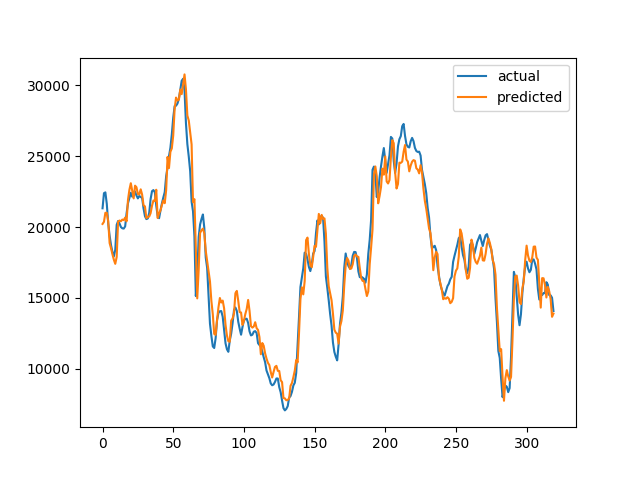

In [79]:
plot_comparison(estimator_Ridge.fit (trn_fea_pdf_lag1_ore, trn_tgt_ser_lag1_ore).predict(tst_fea_pdf_lag1_ore.values),tst_tgt_ser_lag1_ore.values)

## Summary

###Model Selection

Selecting the correct model to predict our bci_5 target variable was no easy task.  We found that after running the initial tests there was a high need to delve further into our grid search and into our pipelines, to truly understand why exactly it was that certain models were more effective than others.  For all three models, PCA analysis and Alpha selection proved to be the most important features to consider, and each model had better efficiency with different values.  We found this interesting in a sense, as all models functioned using some form of regression to do their machine learning, however also not surprising because each model handled the data in slightly different ways.  Ultimately, we were surprised that Elastic Net did not provide any better information than RIDGE or LASSO regression.  Our reasoning behind why it did not is that Ridge Regression is specially formatted to handle multicollinearity and problems associated with correlation between variables.  As the data we were predicting off of had a high chance of correlation, the RIDGE method was best suited to handle the data.  While LASSO attempts to handle multicollinearity by only selecting a subset of predictors, it was not as effective at predicting the data most likely because a large number of the predictors we would have to consider would be text data, and therefore could pollute the model without proper cleaning and processing. Elastic Net, as the intersection of the two models, would provide an answer somewhat in between the two – and this is in fact consistent with what we observed, although Elastic Net tended to be closer to the LASSO regression estimates.  We again attribute this factor to the large amount of textual data.

### Lag 1 against Lag 3

For our models, we found that in every case, we considered the first lagged variables provided a better estimate of the necessary information than the variables that were lagged 3 days behind.  We have several conclusions to draw based on this information and this finding.  First, we determined that this would make sense for reasons of simple proximity – seeing as often times history functions as the best predictor, and what happened yesterday is often a good predictor of what will happen today.  While this is not necessarily a “novel” idea – one other possibility we considered was that the flow of information today is at such speeds that and the gain or loss from knowledge is transferred very quickly through social media and other platforms that three days of lag is too far removed for any realistic impacts.  One point we wished to try but did not get to was crating and building a model with the lagged 3 data, and then testing it out with the one day lagged data.  We would be curious to see the differences in the model building process and understand the potential impacts that such small shifts can have on the model formation.

### Iron Ore V. Coal

Of all our asked questions and test’s we wanted to observe, we found this one to be the most surprising.  Originally, we had assumed that the model built on the Coal dataset would perform better with predicting price (as we trained and tuned the model using Coal) and had intended to build a second model that was trained on the Iron Ore data.  However, upon completing our exploration, we were surprised to see that the Ore dataset provided a different and better result.  We can conclude from this result a couple of things – namely that many of the predictors being considered from PCA are numeric, and most likely not different from those found in the Coal dataset.  Secondly, that the few morsels of natural language contained in our model are in fact more usefully predicted based on the iron ore dataset.  We determine from this that the tags and title of the datasets are impacting the given models, and that if someone is interested in the bci_5 index movements, they should focus their attention on those tweets concerned with iron ore movement and not concerned with coal movements.  Given more time and more advanced coding abilities, we would have liked to seen which specific titles or tags were influential on the data, and ran some code to attempt to determine strings or combinations of tags that could be highly influential.

### Count V. TFIDF

For the vectorizer exploration, we were also surprised to see that there was relatively low impact.  In our originally hypothesis and plan we had figured that tfidf would impact the model one way or another (positively or negatively) but not have only marginal impact.  We believe the reason for this impact is that there is a relatively low amount of impact the twitter data has on the model functionality with all of the other numeric data already considered.  Furthermore, we conclude that although the tfidf material is slightly better the usefulness in a business context is not worth the improvement in model functionality.  While it is nice to have highly accurate models, being able to explain how they work and convince a business manager to utilize it to solve their problem is important, and as the material is already complex, there is no need to complicate it further.